In [1]:
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sqlalchemy import create_engine
import mysql.connector

In [119]:
try:
    connection = mysql.connector.connect(host='localhost',
                                             database='project2',
                                             user='root',
                                             password='MosiSQL$$')
    #Shipping
    cursor = connection.cursor()
    cursor.execute('select * from shipping')
    record = cursor.fetchall()
    dfShipping=pd.DataFrame(record ,columns=[i[0] for i in cursor.description])
    #Order 
    cursor = connection.cursor()
    cursor.execute('select * from `order`')
    record = cursor.fetchall()
    dfOrder  = pd.DataFrame(record , columns=[i[0] for i  in cursor.description])

    # #order_detail 
    cursor = connection.cursor()
    cursor.execute('select * from order_detail')
    record = cursor.fetchall()
    dfOrderDetails = pd.DataFrame(record , columns=[i[0] for i in cursor.description])

    
except mysql.connector.Error as error:
    print("Failed to get record from database: {}".format(error))

finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed")


MySQL connection is closed


In [111]:
# df = pd.merge(dfOrderDetails , dfOrder , on = 'Order ID').drop(columns=['Row ID','Order Date','Customer ID'])
# df = pd.merge(df , dfShipping , on = 'Order ID')
# df = df.drop(columns=['Order ID','Shipping ID','Ship Date','City','State','Region','Product ID'])
# from sklearn.preprocessing import LabelEncoder , OrdinalEncoder
# labelMarket  = LabelEncoder()
# labelPriority = LabelEncoder()
# labelProduct = LabelEncoder()
# labelCountry = LabelEncoder()
# labelShip = LabelEncoder()
# df['Market'] =  labelMarket.fit_transform(df['Market'])
# df['Order Priority'] = labelPriority.fit_transform(df['Order Priority'])
# # df['Product ID'] = labelPriority.fit_transform(df['Product ID'])
# df['Ship Mode'] = labelShip.fit_transform(df['Ship Mode'])
# df['Country'] = labelPriority.fit_transform(df['Country'])

In [120]:
#just for test 
df = pd.merge(dfOrderDetails , dfOrder , on = 'Order ID').drop(columns=['Row ID','Order Date','Customer ID'])
df = pd.merge(df , dfShipping , on = 'Order ID')
df = df.drop(columns=['Order ID','Shipping ID','Ship Date','Product ID'])
from sklearn.preprocessing import LabelEncoder , OrdinalEncoder
labelMarket  = LabelEncoder()
labelPriority = LabelEncoder()
labelProduct = LabelEncoder()
labelCountry = LabelEncoder()
labelShip = LabelEncoder()
labelCity = LabelEncoder()
labelState = LabelEncoder()
labelRegion = LabelEncoder()

enc = LabelEncoder()
df['Market'] =  labelMarket.fit_transform(df['Market'])
df['Order Priority'] = labelPriority.fit_transform(df['Order Priority'])
# df['Product ID'] = labelPriority.fit_transform(df['Product ID'])
df['Ship Mode'] = labelShip.fit_transform(df['Ship Mode'])
df['Country'] = labelCountry.fit_transform(df['Country'])
df['City']  = labelCity.fit_transform(df['City'])
df['State']  = labelState.fit_transform(df['State'])
df['Region']  = labelRegion.fit_transform(df['Region'])

In [121]:
df['Ship Mode'].value_counts()
# df.columns

3    29846
2     9972
0     7232
1     2620
Name: Ship Mode, dtype: int64

In [86]:
df.to_csv('data.csv')

In [122]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy={3: 9972})
X_sm, y_sm = rus.fit_resample(df.drop(['Ship Mode'] , axis=1), df['Ship Mode'])
df  =  pd.concat([X_sm , y_sm],axis=1)

sm = SMOTE(sampling_strategy='auto', k_neighbors=10, random_state=42)
X_sm, y_sm = sm.fit_resample(df.drop(['Ship Mode'] , axis=1), df['Ship Mode'])
df  =  pd.concat([X_sm , y_sm],axis=1)


In [156]:
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(sampling_strategy={3: 9972})
# X_sm, y_sm = rus.fit_resample(df.drop(['Ship Mode'] , axis=1), df['Ship Mode'])
# df  =  pd.concat([X_sm , y_sm],axis=1)


In [139]:
# undersample = NearMiss(version=3, n_neighbors_ver3=3)
# X_sm, y_sm= undersample.fit_resample(df.drop(['Ship Mode'] , axis=1), df['Ship Mode'])
# df  =  pd.concat([X_sm , y_sm],axis=1)

In [123]:
df['Ship Mode'].value_counts()

0    9972
1    9972
2    9972
3    9972
Name: Ship Mode, dtype: int64

In [41]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(sampling_strategy={2: 29846, 0: 29846  ,1: 29846})
# X_sm, y_sm = ros.fit_resample(df.drop(['Ship Mode'] , axis=1), df['Ship Mode'])

In [165]:
# df  =  pd.concat([X_sm , y_sm],axis=1)
# df['Ship Mode'].value_counts()
# df.corr()
# indexList = df.corr()[(df.corr()['Ship Mode']<0.009) & (df.corr()['Ship Mode']>-0.009)].index
# df.drop(indexList.to_list(), axis=1,inplace=True)

In [124]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        print('Job done on column: {}'.format(col))
        
    return df
df  = remove_outliers(df,df.columns,3)
df.columns =df.columns.astype(str)


Working on column: Sales
Job done on column: Sales
Working on column: Quantity
Job done on column: Quantity
Working on column: Discount
Job done on column: Discount
Working on column: Profit
Job done on column: Profit
Working on column: Shipping Cost
Job done on column: Shipping Cost
Working on column: Order Priority
Job done on column: Order Priority
Working on column: Market
Job done on column: Market
Working on column: City
Job done on column: City
Working on column: State
Job done on column: State
Working on column: Country
Job done on column: Country
Working on column: Region
Job done on column: Region
Working on column: Ship Mode
Job done on column: Ship Mode


In [125]:
#Feature selection using mutual information and chi2   
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile ,mutual_info_classif,f_regression
data= df.drop(columns='Ship Mode')
# feature scaling
scaler = MinMaxScaler()
standard = StandardScaler()
scaled = standard.fit_transform(data)
# scaled = data
# feature selection
# selector = SelectKBest(chi2, k=20)
selector = SelectPercentile(mutual_info_classif, percentile=90)

selected = selector.fit_transform(scaled,df['Ship Mode'])

print('Number of features before selection:', data.shape[1])
print('Number of features after selection:', selected.shape[1])
data = pd.DataFrame(selected)


Number of features before selection: 11
Number of features after selection: 9


In [126]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score ,r2_score

x_train, x_test, y_train, y_test = train_test_split(data, df['Ship Mode'], train_size=.90, random_state=42)
x_val , x_test , y_val  , y_test = train_test_split(x_test , y_test , train_size=0.50 , random_state=42)   


In [10]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score ,r2_score

# x_train, x_test, y_train, y_test = train_test_split(df.drop(['Ship Mode'],axis=1), df['Ship Mode'], train_size=.80, random_state=42)

In [127]:
#depoloy a model 
from sklearn.ensemble import RandomForestClassifier
modelForest = RandomForestClassifier(n_estimators = 700 ,bootstrap= False,criterion='log_loss'\
    ,max_features='log2',n_jobs=-1)
modelForest.fit(x_train , y_train)
modelForest.get_params()
pred = modelForest.predict(x_val)
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print('f1_score :',f1_score(y_val,pred,average='macro'))


f1_score : 0.6131699717306026


In [128]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# standard = StandardScaler()
# minMax=MinMaxScaler()
# X_train = minMax.fit_transform(x_train)
# X_test = minMax.transform(x_test)
# model = LogisticRegression(max_iter=200,solver='newton-cg')
modelLog = LogisticRegression()
modelLog.fit(x_train,y_train)
# value  =model.fit(x_test,y_test)
y_pred = modelLog.predict(x_val)
print('f1_score metrics of logistic regression classfier on test set :',f1_score(y_val, y_pred,average='macro'))
# print(r2_score(y_test , y_pred))
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(modelLog.score(x_train, y_train)))
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(modelLog.score(x_val, y_val)))
print('Precision of logistic regression classifier on val set: {:.2f}'.format(precision_score(y_val, y_pred,average='macro')))

f1_score metrics of logistic regression classfier on test set : 0.3264863052947581
Accuracy of logistic regression classifier on train set: 0.38
Accuracy of logistic regression classifier on val set: 0.38
Precision of logistic regression classifier on val set: 0.33


In [129]:
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
gradient_booster = GradientBoostingClassifier(learning_rate=0.1,warm_start=True)
gradient_booster.fit(x_train,y_train)
print(classification_report(y_val,gradient_booster.predict(x_val)))

              precision    recall  f1-score   support

           0       0.47      0.42      0.44       467
           1       0.53      0.58      0.56       461
           2       0.40      0.32      0.35       428
           3       0.56      0.68      0.61       487

    accuracy                           0.50      1843
   macro avg       0.49      0.50      0.49      1843
weighted avg       0.49      0.50      0.49      1843



In [ ]:
from flaml import AutoML
automl = AutoML()
automl.fit(x_train, y_train, task='classification')

In [130]:
# from keras.models import Sequential
# from keras.layers import Dense, SimpleRNN
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# import math
# import matplotlib.pyplot as plt
# import keras 
# from keras.optimizers import RMSprop , SGD , Adam
# from keras.callbacks import EarlyStopping 
# from sklearn import preprocessing 
# from sklearn.preprocessing import scale


In [131]:
# modelDeep = Sequential() 
# modelDeep.add(Dense(9, kernel_initializer = 'normal', activation = 'relu',input_shape = (9,))) 
# modelDeep.add(Dense(9, activation = 'relu'))
# modelDeep.add(Dense(9, activation = 'relu'))
# modelDeep.add(Dense(4,  activation='sigmoid'))

In [132]:
# modelDeep.compile(
#    loss=keras.losses.CategoricalCrossentropy(), 
#    optimizer = 'adam', 
#    metrics = 'mean_absolute_error'
# )

In [17]:
# history = modelDeep.fit(
#    x_train.values, keras.utils.to_categorical(y_train.values, num_classes=4)
# ,    
#    batch_size=32, 
#    epochs = 500, 
#    verbose = 1, 
#    validation_split = 0.2, 
#    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 30)]
# )

Epoch 1/500
798/798 [==============================] - 4s 3ms/step - loss: 1.2895 - mean_absolute_error: 0.4755 - val_loss: 1.2577 - val_mean_absolute_error: 0.4633
Epoch 2/500
798/798 [==============================] - 2s 3ms/step - loss: 1.2524 - mean_absolute_error: 0.4594 - val_loss: 1.2485 - val_mean_absolute_error: 0.4565
Epoch 3/500
798/798 [==============================] - 2s 3ms/step - loss: 1.2437 - mean_absolute_error: 0.4552 - val_loss: 1.2392 - val_mean_absolute_error: 0.4525
Epoch 4/500
798/798 [==============================] - 2s 3ms/step - loss: 1.2355 - mean_absolute_error: 0.4517 - val_loss: 1.2322 - val_mean_absolute_error: 0.4513
Epoch 5/500
798/798 [==============================] - 2s 3ms/step - loss: 1.2272 - mean_absolute_error: 0.4491 - val_loss: 1.2250 - val_mean_absolute_error: 0.4476
Epoch 6/500
798/798 [==============================] - 2s 3ms/step - loss: 1.2206 - mean_absolute_error: 0.4461 - val_loss: 1.2190 - val_mean_absolute_error: 0.4426
Epoch 7/50

In [81]:
# score = modelDeep.evaluate(x_test.values, y_test.values, verbose = 0) 
# print('Test loss:', score[0]) 
# print('Test accuracy:', score[1])
# prediction = modelDeep.predict(x_test.values)
# y_train

In [82]:
# keras.utils.to_categorical(y_train.values, num_classes=4)

In [ ]:
# # prediction.tolist()
# print('f1_score :',f1_score(keras.utils.to_categorical(y_test.values, num_classes=4),\
#     prediction,average='macro'))


In [83]:
# prediction

In [ ]:
# # multi-class classification with Keras
# import pandas
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.utils import np_utils
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import LabelEncoder
# from sklearn.pipeline import Pipeline
# # load dataset


# # convert integers to dummy variables (i.e. one hot encoded)
# dummy_y = np_utils.to_categorical(y_train)
 
# # define baseline model
# def baseline_model():
#  # create model
#  model = Sequential()
#  model.add(Dense(9, input_dim=9, activation='relu'))
#  model.add(Dense(4, activation='softmax'))
#  # Compile model
#  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#  return model
 
# estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=5, verbose=0)
# kfold = KFold(n_splits=10, shuffle=True)
# results = cross_val_score(estimator, x_train.values, dummy_y, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [32]:
model = Sequential()
model.add(Dense(9, input_dim = x_train.shape[1], activation = 'relu')) # input layer requires input_dim param
model.add(Dense(9, activation = 'relu'))
model.add(Dense(9, activation = 'relu'))
model.add(Dense(4, activation='sigmoid'))

model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])
yT = keras.utils.to_categorical(y_train.values, num_classes=4)
#es = EarlyStopping(monitor='loss', min_delta=0.005, patience=1, verbose=1, mode='auto')
model.fit(x_train.values, yT, epochs = 500, shuffle = True, batch_size=64, verbose=2,callbacks = [EarlyStopping(monitor = 'loss', patience = 30)])

print(model.metrics_names[0], model.metrics_names[1])

Epoch 1/500
519/519 - 2s - loss: 1.2943 - accuracy: 0.3594 - 2s/epoch - 4ms/step
Epoch 2/500
519/519 - 1s - loss: 1.2502 - accuracy: 0.3854 - 866ms/epoch - 2ms/step
Epoch 3/500
519/519 - 1s - loss: 1.2433 - accuracy: 0.3906 - 868ms/epoch - 2ms/step
Epoch 4/500
519/519 - 1s - loss: 1.2380 - accuracy: 0.3951 - 865ms/epoch - 2ms/step
Epoch 5/500
519/519 - 1s - loss: 1.2336 - accuracy: 0.3972 - 845ms/epoch - 2ms/step
Epoch 6/500
519/519 - 1s - loss: 1.2295 - accuracy: 0.4008 - 917ms/epoch - 2ms/step
Epoch 7/500
519/519 - 1s - loss: 1.2229 - accuracy: 0.4040 - 1s/epoch - 2ms/step
Epoch 8/500
519/519 - 1s - loss: 1.2145 - accuracy: 0.4100 - 1s/epoch - 2ms/step
Epoch 9/500
519/519 - 1s - loss: 1.2053 - accuracy: 0.4151 - 829ms/epoch - 2ms/step
Epoch 10/500
519/519 - 1s - loss: 1.1964 - accuracy: 0.4196 - 958ms/epoch - 2ms/step
Epoch 11/500
519/519 - 1s - loss: 1.1905 - accuracy: 0.4239 - 943ms/epoch - 2ms/step
Epoch 12/500
519/519 - 1s - loss: 1.1849 - accuracy: 0.4295 - 1s/epoch - 2ms/step
E

In [41]:
val = keras.utils.to_categorical(y_val.values, num_classes=4)

scores = model.evaluate(x_val.values, val)
# print(model.metrics_names[0], model.metrics_names[1])
prediction = model.predict(x_val.values)
# print('f1_score :',f1_score(test,prediction,average='macro'))


58/58 [==============================] - 0s 2ms/step


In [43]:
# pd.DataFrame(prediction).iloc[0]
# y_test
result = []
for i in range(prediction.shape[0]):
    result.append(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
result
print('f1_score :',f1_score(y_val,result,average='macro'))


f1_score : 0.46320259633073557


58/58 [==============================] - 0s 3ms/step


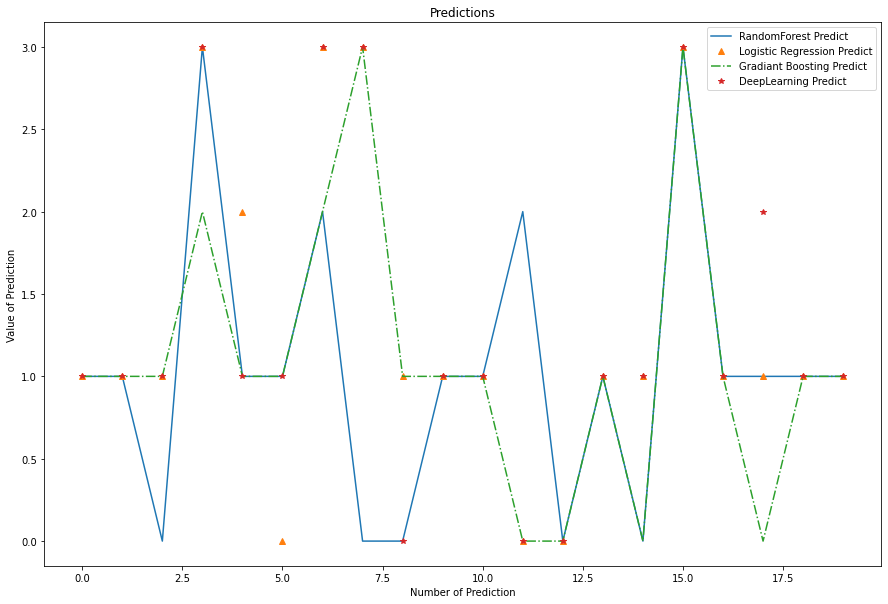

In [83]:
import matplotlib.pyplot as plt
prediction = model.predict(x_test.values)
result = []
for i in range(prediction.shape[0]):
    result.append(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
result


forestAnswer = modelForest.predict(x_test)
gradAnswer = gradient_booster.predict(x_test)
logAnswer = modelLog.predict(x_test) 
plt.figure(figsize=(15,10))

x = list(range(0, len(x_test)))
plt.plot(x[:20], list(forestAnswer)[:20], label ='RandomForest Predict')
plt.plot(x[:20], list(logAnswer)[:20],'^',label ='Logistic Regression Predict')
plt.plot(x[:20], list(gradAnswer)[:20], '-.', label ='Gradiant Boosting Predict')
plt.plot(x[:20], list(result)[:20], '*', label ='DeepLearning Predict')

plt.xlabel("Number of Prediction")
plt.ylabel("Value of Prediction")
plt.title('Predictions')
plt.legend()

plt.show()


In [89]:
from numpy.linalg import norm
cosine = np.dot(forestAnswer,result)/(norm(forestAnswer)*norm(result))
print('Cosine Similarity Between Forest and Deep',cosine)
cosine = np.dot(forestAnswer,logAnswer)/(norm(forestAnswer)*norm(logAnswer))
print('Cosine Similarity Between Forest and Logistic',cosine)
cosine = np.dot(result,logAnswer)/(norm(result)*norm(logAnswer))
print('Cosine Similarity Between Deep and log',cosine)
cosine = np.dot(result,gardAnswer)/(norm(result)*norm(gradAnswer))
print('Cosine Similarity Between Deep and gradBoost',cosine)
cosine = np.dot(forestAnswer,gardAnswer)/(norm(forestAnswer)*norm(gradAnswer))
print('Cosine Similarity Between Forest and gradBoost',cosine)
cosine = np.dot(logAnswer,gardAnswer)/(norm(logAnswer)*norm(gradAnswer))
print('Cosine Similarity Between logistic and gradBoost',cosine)


Cosine Similarity Between Forest and Deep 0.8864456368391062
Cosine Similarity Between Forest and Logistic 0.8563047970371374
Cosine Similarity Between Deep and log 0.8834306617722237
Cosine Similarity Between Deep and gradBoost 0.9193141641681019
Cosine Similarity Between Forest and gradBoost 0.877997418320137
Cosine Similarity Between logistic and gradBoost 0.9264049423249909


In [92]:
print('r2_score for test set in forrstModel:',f1_score(forestAnswer,y_test,average='macro'))
print('r2_score for test set in deepModel:',f1_score(result,y_test,average='macro'))
print('r2_score for test set in logModel:',f1_score(logAnswer,y_test,average='macro'))
print('r2_score for test set in gradBoosting:',f1_score(gradAnswer,y_test,average='macro'))


r2_score for test set in forrstModel: 0.6009008565028808
r2_score for test set in deepModel: 0.4686466225949742
r2_score for test set in logModel: 0.3384548711102403
r2_score for test set in gradBoosting: 0.4874207208130583


In [173]:
forestAnswer = modelForest.predict(x_test)

pd.DataFrame(forestAnswer,labelShip.inverse_transform(forestAnswer)).reset_index().rename(columns={0:'Mode Id','index':'Ship Mode'}).to_csv('ML2 Predicted.csv')
pd.DataFrame(y_test.values,labelShip.inverse_transform(y_test.values)).reset_index().rename(columns={0:'Mode Id','index':'Ship Mode'}).to_csv('ML2 Actual.csv')